In [1]:
%load_ext autoreload
%autoreload 2

## DCR Slope Precision Metric

<br>**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 08-14-20
<br>**Short description:**
This notebook build upon Peter Yoachim's `DcrPrecisionMetric` demonstrated [here](https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/metrics/dcrMetric.py). Two goals set to achieve in this notebook: 
1. Demonstrate the scaling relationship for Peter's slope uncertainty
2. Investigate the Bevington method to compute slope uncertainty and compare it to Peters'

### 0. Software Setup

In [2]:
your_username = 'ywx649999311'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

mpl.rcParams['figure.dpi'] = 100

Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

In [5]:
# import dask and create client
from dask.distributed import Client
client = Client(n_workers=16)
client

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Client Scheduler: tcp://127.0.0.1:44280,Cluster Workers: 16 Cores: 16 Memory: 257.77 GB


## 1. The Metric
### 1.1 Define the metric

In [12]:
from lsst.sims.maf.metrics import BaseMetric

from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils.astrometryUtils import m52snr, astrom_precision, sigma_slope

class AGN_DCR(BaseMetric):
    """AGN DCR"""
    
    def __init__(self, band, src_mag=22, seeingCol='seeingFwhmGeom', m5Col='fiveSigmaDepth',
                 PACol='paraAngle', filterCol='filter', atm_err=0.01, Bv=True, PA=False, **kwargs):
        
        self.band = band # required
        self.src_mag = src_mag
        self.m5Col = m5Col
        self.PACol = PACol
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.atm_err = 0.01
        self.Bv = Bv
        self.PA = PA
        self.metricName = f'DCR_{src_mag}_{self.band}'
        
        cols=['airmass', self.filterCol, self.m5Col, self.PACol, self.seeingCol]
        super(AGN_DCR, self).__init__(col=cols, metricName=self.metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # get the data only corresponding the the desired filter
        data_filt = dataSlice[np.where(dataSlice[self.filterCol] == self.band)]
        
        # Compute the SNR from the observed mag and limiting mag
        # https://sims-maf.lsst.io/_modules/lsst/sims/maf/utils/astrometryUtils.html#m52snr
        snr = m52snr(self.src_mag, data_filt[self.m5Col])

        # The positional error is just the seeing scaled by the SNR with the error floor added in quadrature
        # https://sims-maf.lsst.io/_modules/lsst/sims/maf/utils/astrometryUtils.html#astrom_precisio
        pos_var = np.power(astrom_precision(data_filt[self.seeingCol], snr), 2) \
                  + self.atm_err**2
        pos_err = np.sqrt(pos_var)
        
        # compute tan(Z)
        zenith = np.arccos(1/data_filt['airmass'])
        
        # check if use the Bevington version
        if not self.Bv:
            # check if use Peter's PA term
            # note that the PA drops out in the end anyway
            if not self.PA:
                x_coord = np.tan(zenith)
                slope_uncerts = pos_err/x_coord
                total_slope_uncert = 1./np.sqrt(np.sum(1./slope_uncerts**2))

            else:
                # compute projection of DCR offset onto RA and Dec
                x_coord = np.tan(zenith)*np.sin(np.radians(dataSlice[self.PACol]))
                x_coord2 = np.tan(zenith)*np.cos(np.radians(dataSlice[self.PACol]))

                # function is of form, y=ax. a=y/x. da = dy/x.
                # Only strictly true if we know the unshifted position. But this should be a reasonable approx            
                slope_uncerts = pos_err/x_coord
                slope_uncerts2 = pos_err/x_coord2

                # error propagation
                # Assuming we know the unshfted position of the object (or there's little covariance if we are fitting for both)
                total_slope_uncert = 1./np.sqrt(np.sum(1./slope_uncerts**2)+np.sum(1./slope_uncerts2**2))

            result = total_slope_uncert
        
        else:
            
            ## version from Bevington page 109 from least-square
            x_coord = np.tan(zenith)
            result = sigma_slope(x_coord, pos_err)
        
        return result

/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metrics/baseMetric.py:39: UserWarning: Redefining metric __main__.AGN_DCR! (there are >1 metrics with the same name)
  warnings.warn('Redefining metric %s! (there are >1 metrics with the same name)' % (metricname))


In [5]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'

# temporary dir for testing
tmp_OutDir = f'../tmp/DCR/0814/ResultDBs/'
tmp_metricDataPath = f'../tmp/DCR/0814/MetricData/'

# dir to store data for sharing
outDir = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/DCR/0814/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/DCR/0814/MetricData/'

for path in [tmp_OutDir, tmp_metricDataPath, outDir, metricDataPath]:
    if not os.path.exists(os.path.abspath(path)):
        os.makedirs(os.path.abspath(path))

In [7]:
opsdb = db.OpsimDatabase(os.path.join(dbDir, 'baseline_v1.5_10yrs.db'))
resultDb = db.ResultsDb(outDir = tmp_OutDir)

### 1.2 Run metrics for comparision on Baseline cadence
We will run g band DCR precision at mag = 20 and 22 with two methods.

In [60]:
bundleDict = {}
for gmag in [20, 22]:
    
    # declare metric, slicer and sql contraint
    DCR_metricG = AGN_DCR('g', src_mag=gmag)
    slicer = slicers.HealpixSlicer(nside=64)
    constraintG = 'filter = "g"'
    constraintG += ' and note not like "DD%"'
    constraintG += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbG = metricBundles.MetricBundle(DCR_metricG, slicer, constraintG)
    summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
    DCR_mbG.setSummaryMetrics(summaryMetrics)
    
    # declare metric, slicer and sql contraint
    DCR_metricG_Bv = AGN_DCR('g', src_mag=gmag, Bv=True)
    DCR_metricG_Bv.metricName = DCR_metricG.metricName + '_Bv'
    slicer = slicers.HealpixSlicer(nside=64)
    constraintG = 'filter = "g"'
    constraintG += ' and note not like "DD%"'
    constraintG += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbG_Bv = metricBundles.MetricBundle(DCR_metricG_Bv, slicer, constraintG)
    summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
    DCR_mbG_Bv.setSummaryMetrics(summaryMetrics)

    # put into dict
    bundleDict[DCR_metricG.metricName] = DCR_mbG
    bundleDict[DCR_metricG_Bv.metricName] = DCR_mbG_Bv

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [61]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=tmp_OutDir, resultsDb=resultDb)
group.runAll()

Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" and proposalId = 1 for columns ['filter', 'fieldRA', 'seeingFwhmGeom', 'paraAngle', 'fiveSigmaDepth', 'airmass', 'fieldDec']
Found 173012 visits
Running:  ['DCR_20_g', 'DCR_20_g_Bv', 'DCR_22_g', 'DCR_22_g_Bv']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in sqrt
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### 2. Derive & Test the Scaling Relationship

<span style='color:red'>__IMPORTANT:__</span> From the plot shown a few cells below, the slope uncertainty actually doesn't scale nor the astrometric precision due the error floor `atm_err`. So the derivation shown below is useless but a good excersice. 

Let's first dervie it. The derivation is based on Peter's version for calculating the fitted slope uncertainty. We will use $\sigma_{total}$ to denote the 'total_slope_uncerts' and $\sigma_{arr}$ to denote the 'slope_uncerts' in the __AGN_DCR__ metric above. Note that we will not use the PA in the calculation as the PA terms will drop out in the end anyway.

$$ \log\,(\sigma_{total}) = -\frac{1}{2}\log\,(\sum \frac{1}{\sigma_{arr}^{2}}) ~and~ \sigma_{arr} = \frac{\Delta y}{x}$$
=> 
$$\log\,(\sigma_{total}) = -\frac{1}{2}\log\,(\sum \frac{x^{2}}{(\Delta y)^{2}})$$

Meanwhile:
$$\Delta y = seeing/snr = seeing/5*10^{-0.4*(m-m5)}$$
=>
$$\log\,(\Delta y) = \log\,(seeing) + \log\,(1/5) + 0.4*(m-m5)*\log\,(10)$$

Consider the seeing doesn't change as we change the source magnitude, if we use $\Delta y_{0}$ denote the astrometric error for a reference magnitude and $\Delta y_{1}$ denote the astrometric error at an arbitrary magnitude, then: 

$$\log\,(\Delta y_{1}/\Delta y_{0}) = 0.4*(m_{1} - m5)*\log(10) - 0.4*(m_{0} - m5)*\log(10) = 0.4*\log(10)*(m_{1} - m_{0})$$

If we set $\Delta y_{1}/\Delta y_{0} = \alpha$, then for an arbitrary source magnitde,

$$\log(\sigma_{total}) = -\frac{1}{2}\log\,(\sum \frac{x^{2}}{(\Delta y_{0})^{2}*\alpha^{2}})$$
=>
$$\log(\sigma_{total}) = -\frac{1}{2}\log\,(\alpha^{-2}*\sum \frac{x^{2}}{(\Delta y_{0})^{2}}) 
                       = -\frac{1}{2}\log\,(\sum \frac{x^{2}}{(\Delta y_{0})^{2}}) + \log(\alpha)
                       = \log(\sigma_{total\_ref}) + 0.4*\log(10)*(m_{1} - m_{0})$$
                       
where in the equation above $\log(\sigma_{total})$ is the log of the total slope uncertainty at an arbitrary source magnitude and $\log(\sigma_{total\_ref})$ is the total slope uncertainty at the reference magnitude. 

Next, let's put the above derviation into a function

In [62]:
# This function assumes data in a numpy array-like structure
def dcr_scale(data, ref_mag, src_mag):

    ln_uncert = np.log(data) + 0.4*(src_mag - ref_mag)    
    return np.exp(ln_uncert)

In [63]:
# use the 20th mag as reference as compute the 22nd mag slope undertainty
mask_20 = group.bundleDict['DCR_20_g'].metricValues.mask
data_20 = group.bundleDict['DCR_20_g'].metricValues.data[~mask_20]
data_20 = data_20[~(np.isnan(data_20) | np.isinf(data_20))]

mask_22 = group.bundleDict['DCR_22_g'].metricValues.mask
data_22 = group.bundleDict['DCR_22_g'].metricValues.data[~mask_22]
data_22 = data_22[~(np.isnan(data_22) | np.isinf(data_22))]

data_22_scale = dcr_scale(data_20, 20, 22)

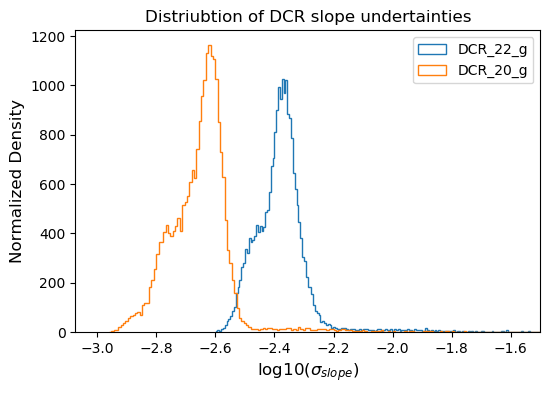

In [79]:
# now let's plot to see any difference
plt.hist(np.log10(data_22), histtype='step', label='DCR_22_g', bins='fd')
plt.hist(np.log10(data_20), histtype='step', label='DCR_20_g', bins='fd')
plt.xlim(right=-1.5)
plt.xlabel('log10($\\sigma_{slope}$)', fontsize=12)
plt.ylabel('Normalized Density', fontsize=12)
plt.title('Distriubtion of DCR slope undertainties')
plt.legend(loc=1)

<span style='color:red'>__Conclusion:__</span> The slope uncertainties DO NOT scale lineraly in the log space with the source magnidue because of the `atm_err` term (see the metric definition) in the calculation of the astrometric precision. 

## 3. Compare two methods to compute slope uncertainty
__Note:__ Labels end with `*_Bv` representing the Bevington version

In [68]:
mask_20_Bv = group.bundleDict['DCR_20_g_Bv'].metricValues.mask
data_20_Bv = group.bundleDict['DCR_20_g_Bv'].metricValues.data[~mask_20_Bv]
data_20_Bv = data_20_Bv[~(np.isnan(data_20_Bv) | np.isinf(data_20_Bv))]

mask_22_Bv = group.bundleDict['DCR_22_g_Bv'].metricValues.mask
data_22_Bv = group.bundleDict['DCR_22_g_Bv'].metricValues.data[~mask_22_Bv]
data_22_Bv = data_22_Bv[~(np.isnan(data_22_Bv) | np.isinf(data_22_Bv))]

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


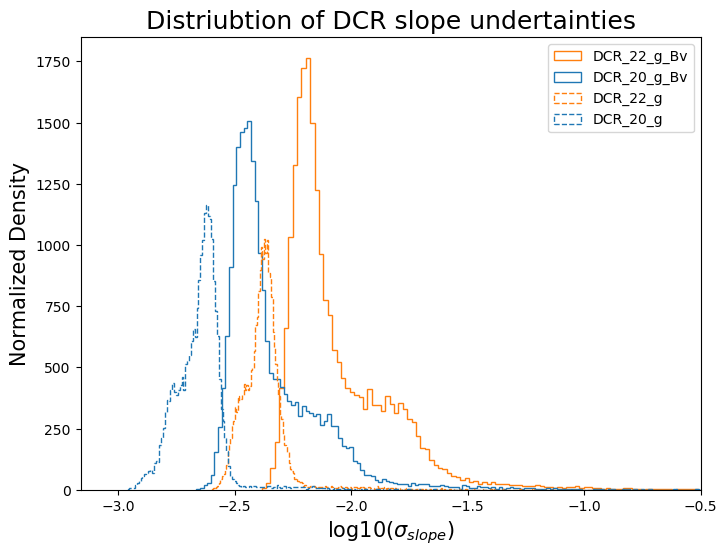

In [95]:
fig = plt.figure(figsize=(8,6))
plt.hist(np.log10(data_22_Bv[data_22_Bv < 100]), histtype='step', \
         label='DCR_22_g_Bv', bins='fd', color='tab:orange')
plt.hist(np.log10(data_20_Bv[data_20_Bv < 100]), histtype='step', \
         label='DCR_20_g_Bv', bins='fd', color='tab:blue')
plt.hist(np.log10(data_22), histtype='step', label='DCR_22_g', \
         bins='fd', color='tab:orange', linestyle='--')
plt.hist(np.log10(data_20), histtype='step', label='DCR_20_g', \
         bins='fd', color='tab:blue', linestyle='--')
plt.xlim(right=-0.5)
plt.xlabel('log10($\\sigma_{slope}$)', fontsize=15)
plt.ylabel('Normalized Density', fontsize=15)
plt.title('Distriubtion of DCR slope undertainties', fontsize=18)
plt.legend(loc=1)